# K-Nearest Neighbor - Supervised Machine Learning - Classification

## Introduction and Learning Goals

In this lab, we explore classification using the K-Nearest Neighbors approach. We use a customer churn dataset from the telecom industry which includes customer data, usage of long-distance, data usage, monthly revenue, type of offerings, and other services purchased by customers. The data, based on a fictional telecom firm, include several Excel files which have been combined and are available in the course materials. We are using the subset of customers who have phone accounts. Since the data include a mix of numeric, categorical, and ordinal variables, we will load this data and do some preprocessing, then use K-nearest neighbors to predict customer churn rates.

After completing this lab, you should have a working understanding of how to preprocess a variety of variables in order to apply the K-Nearest Neighbors algorithm, understand how to choose K, and understand how to evaluate model performance.

In [86]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, seaborn as sns

## Import Data

### Goal: 

To predict the likelikhood of a customer churning vs. not churning

* We begin by importing the data. Examine the columns and data.


* Notice that the data contains a unique ID, an indicator for phone customer status, total lifetime value, total revenue, and a bank-estimated churn score. We will not be using these features, so they can be dropped from the data.


* Begin by taking an initial look at the data, including both numeric and non-numeric features.

In [87]:
churndata = pd.read_pickle("churndata.pkl")

In [88]:
churndata

,id,months,offer,phone,multiple,internet_type,gb_mon,security,backup,protection,...,unlimited,contract,paperless,payment,monthly,total_revenue,satisfaction,churn_value,churn_score,cltv
0,8779-QRDMV,1,None,No,No,DSL,8,No,No,Yes,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,59.65,3,1,91,5433
1,7495-OOKFY,8,Offer E,Yes,Yes,Fiber Optic,17,No,Yes,No,...,Yes,Month-to-Month,Yes,Credit Card,80.65,1024.10,3,1,69,5302
2,1658-BYGOY,18,Offer D,Yes,Yes,Fiber Optic,52,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1910.88,2,1,81,3179
3,4598-XLKNJ,25,Offer C,Yes,No,Fiber Optic,12,No,Yes,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2995.07,2,1,88,5337
4,4846-WHAFZ,37,Offer C,Yes,Yes,Fiber Optic,14,No,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,3102.36,2,1,67,2793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,72,None,Yes,No,None,0,No,No,No,...,No,Two Year,Yes,Bank Withdrawal,21.15,3039.53,5,0,45,5306
7039,6840-RESVB,24,Offer C,Yes,Yes,Cable,24,Yes,No,Yes,...,Yes,One Year,Yes,Mailed Check,84.80,2807.47,3,0,59,2140
7040,2234-XADUH,72,None,Yes,Yes,Fiber Optic,59,No,Yes,Yes,...,Yes,One Year,Yes,Credit Card,103.20,9453.04,4,0,71,5560
7041,4801-JZAZL,11,None,No,No,DSL,17,Yes,No,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,319.21,4,0,59,2793


In [89]:
df = churndata.drop(columns=['id', 'phone', 'total_revenue', 'cltv', 'churn_score'])

In [90]:
round(df.describe(),2)

,months,gb_mon,monthly,satisfaction,churn_value
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.39,20.52,64.76,3.24,0.27
std,24.54,20.42,30.09,1.20,0.44
min,1.00,0.00,18.25,1.00,0.00
25%,9.00,3.00,35.50,3.00,0.00
50%,29.00,17.00,70.35,3.00,0.00
75%,55.00,27.00,89.85,4.00,1.00
max,72.00,85.00,118.75,5.00,1.00


In [91]:
df.describe(include='object')

,offer,multiple,internet_type,security,backup,protection,support,unlimited,contract,paperless,payment
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,6,2,4,2,2,2,2,2,3,2,3
top,None,No,Fiber Optic,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal
freq,3877,4072,3035,5024,4614,4621,4999,4745,3610,4171,3909


# Pre-Process Data for KNN

* Identify which variables are binary, categorical and not ordinal, categorical and ordinal, and numeric.  The non-numeric features will need to be encoded using methods we have discussed in the course.


* Start by identifying the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables. 


* Note that the variable 'months' can be treated as numeric, but it may be more convenient to transform it to an ordinal variable.


* For the other categorical variables, examine their values to determine which may be encoded ordinally.

Identify number of unique values in each variable

In [92]:
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
months,72
offer,6
multiple,2
internet_type,4
gb_mon,50
security,2
backup,2
protection,2
support,2


### a. Binary Variables

Have 2 values

In [93]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['multiple',
 'security',
 'backup',
 'protection',
 'support',
 'unlimited',
 'paperless',
 'churn_value']

### b. Categorical Variables

Except binary values, get variables with unique values greater than 2 and less than 6

In [94]:
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['offer', 'internet_type', 'contract', 'payment', 'satisfaction']

In [95]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['offer', ['None', 'Offer E', 'Offer D', 'Offer C', 'Offer B', 'Offer A']],
 ['internet_type', ['DSL', 'Fiber Optic', 'Cable', 'None']],
 ['contract', ['Month-to-Month', 'One Year', 'Two Year']],
 ['payment', ['Bank Withdrawal', 'Credit Card', 'Mailed Check']],
 ['satisfaction', [3, 2, 1, 4, 5]]]

### c. Ordinal Variables 

Contract: 1 year > 1 month etc.

In [96]:
ordinal_variables = ['contract', 'satisfaction']

In [97]:
df['months'].unique()

array([ 1,  8, 18, 25, 37, 27, 58, 15,  7, 11,  3, 13, 16, 24,  4, 32, 54,
        2, 21, 55,  5, 20, 65, 49, 43, 56, 52, 33, 30, 46,  9, 10, 35, 44,
       62, 14, 12, 17, 39, 68, 34, 22, 19, 23, 42, 41, 57, 38, 29, 66, 69,
       40, 31, 59, 36, 45, 53, 70, 47, 50, 51, 72, 26,  6, 28, 48, 61, 71,
       60, 64, 67, 63])

In [98]:
ordinal_variables.append('months')

### d. Numeric Variables

All columns minus binaries, categoricals, ordinal

In [99]:
numeric_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))

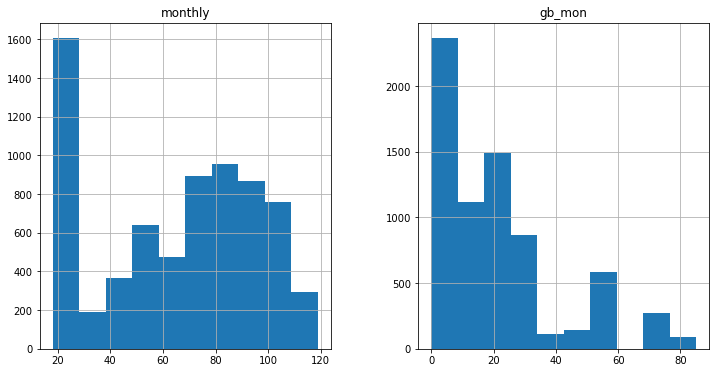

In [100]:
df[numeric_variables].hist(figsize=(12, 6))
plt.show()

In [101]:
df['months'] = pd.cut(df['months'], bins=5)

In [102]:
df.months

0       (0.929, 15.2]
1       (0.929, 15.2]
2        (15.2, 29.4]
3        (15.2, 29.4]
4        (29.4, 43.6]
            ...      
7038     (57.8, 72.0]
7039     (15.2, 29.4]
7040     (57.8, 72.0]
7041    (0.929, 15.2]
7042     (57.8, 72.0]
Name: months, Length: 7043, dtype: category
Categories (5, interval[float64, right]): [(0.929, 15.2] < (15.2, 29.4] < (29.4, 43.6] < (43.6, 57.8] < (57.8, 72.0]]

# Scaling Steps

* Having set up the variables, remember that the K-nearest neighbors algorithm uses distance and hence requires scaled data. 


* Scale the data using one of the scaling methods discussed in the course.


* Save the processed dataframe as a comma-separated file: 'churndata_processed.csv'

In [103]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [104]:
lb, le = LabelBinarizer(), LabelEncoder()

**Encode Strings with Label Encoder for each Binary, Categorical, Ordinal variables:**

We cannot pass strings into our model 

- **Ordinal**:

Given our ordinal variables are already in alphabetical order we can use the Label Encoder else we need to use the Ordinal Encoder and need to ensure we specify which of the values goes first, second, etc.

In [105]:
for column in ordinal_variables:
    df[column] = le.fit_transform(df[column])

In [106]:
df[ordinal_variables].astype('category').describe()

,contract,satisfaction,months
count,7043,7043,7043
unique,3,5,5
top,0,2,0
freq,3610,2665,2470


In [107]:
df.months.head()

0    0
1    0
2    1
3    1
4    2
Name: months, dtype: int64

- **Binary**:

use the Label Binarizer

In [108]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

- **Categorical**:

Are the unique categorical minus the unique cardinal (the intersection)

In [109]:
categorical_variables = list(set(categorical_variables) - set(ordinal_variables))

#### Dummy Variable Creation

There may still be variables that are categorical but not ordinal etc. so we want to ensure we one hot encode those too.

In [110]:
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True) ## multi-collinearity

In [111]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
months,7043.0,1.734204,1.592924,0.00,0.0,1.00,3.00,4.00
multiple,7043.0,0.421837,0.493888,0.00,0.0,0.00,1.00,1.00
gb_mon,7043.0,20.515405,20.418940,0.00,3.0,17.00,27.00,85.00
security,7043.0,0.286668,0.452237,0.00,0.0,0.00,1.00,1.00
backup,7043.0,0.344881,0.475363,0.00,0.0,0.00,1.00,1.00
protection,7043.0,0.343888,0.475038,0.00,0.0,0.00,1.00,1.00
support,7043.0,0.290217,0.453895,0.00,0.0,0.00,1.00,1.00
unlimited,7043.0,0.673719,0.468885,0.00,0.0,1.00,1.00,1.00
contract,7043.0,0.754792,0.848468,0.00,0.0,0.00,2.00,2.00
paperless,7043.0,0.592219,0.491457,0.00,0.0,1.00,1.00,1.00


**Scale all Numerical Variables**

for the KNN model

In [112]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

Tranform integer or larger values:

In [113]:
for column in [ordinal_variables + numeric_variables]:
    df[column] = mm.fit_transform(df[column])

In [114]:
round(df.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
months,7043.0,0.434,0.398,0.0,0.000,0.250,0.750,1.0
multiple,7043.0,0.422,0.494,0.0,0.000,0.000,1.000,1.0
gb_mon,7043.0,0.241,0.240,0.0,0.035,0.200,0.318,1.0
security,7043.0,0.287,0.452,0.0,0.000,0.000,1.000,1.0
backup,7043.0,0.345,0.475,0.0,0.000,0.000,1.000,1.0
protection,7043.0,0.344,0.475,0.0,0.000,0.000,1.000,1.0
support,7043.0,0.290,0.454,0.0,0.000,0.000,1.000,1.0
unlimited,7043.0,0.674,0.469,0.0,0.000,1.000,1.000,1.0
contract,7043.0,0.377,0.424,0.0,0.000,0.000,1.000,1.0
paperless,7043.0,0.592,0.491,0.0,0.000,1.000,1.000,1.0


In [115]:
# Save a copy of the processed data for later use
outputfile = 'churndata_processed.csv'
df.to_csv(outputfile, index=False)

# K-Nearest Neighbors

### Pros

- Simple to implement (does not require estimation)


- Adapts well as new training data is introduced


- Easy to interpret

### Cons

- Slow to predict because many distance calculations 


- Does not generate insight into the data generating process (there is no model)


- Requires a lot of memory as it has to store a lot of data as it grows


- When there are many predictors, KNN accuracy can break down due to the **Curse of Dimensionality** (as distances are further and further away as we increase dimensions)

## Importance of Choosing Odd Neighbor Counts

Choosing odd neighbours is important as it serves the purpose of being a **tie breaker** for predicting whether our new data point belongs to what class.

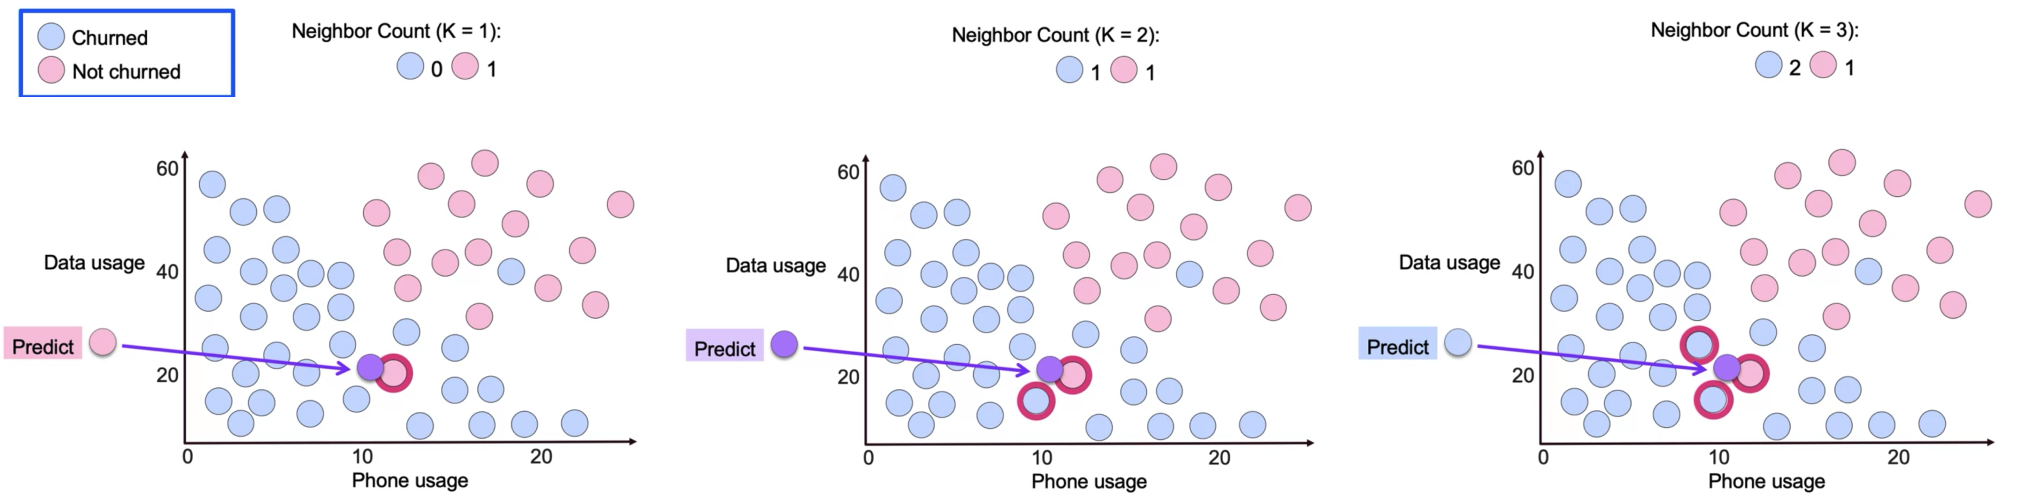

By using odd Neighbour Counts, we can increase the likelihood of correct classification as shown in the above image.

# Requirements for a KNN Model

## 1. Correct value for K

We have to find the correct value of K such that there is no over nor underfitting, i.e. find the optimal decision boundary.

### Underfitting: K = All

Highly biased

### Overfitting: K = 1

High Variance

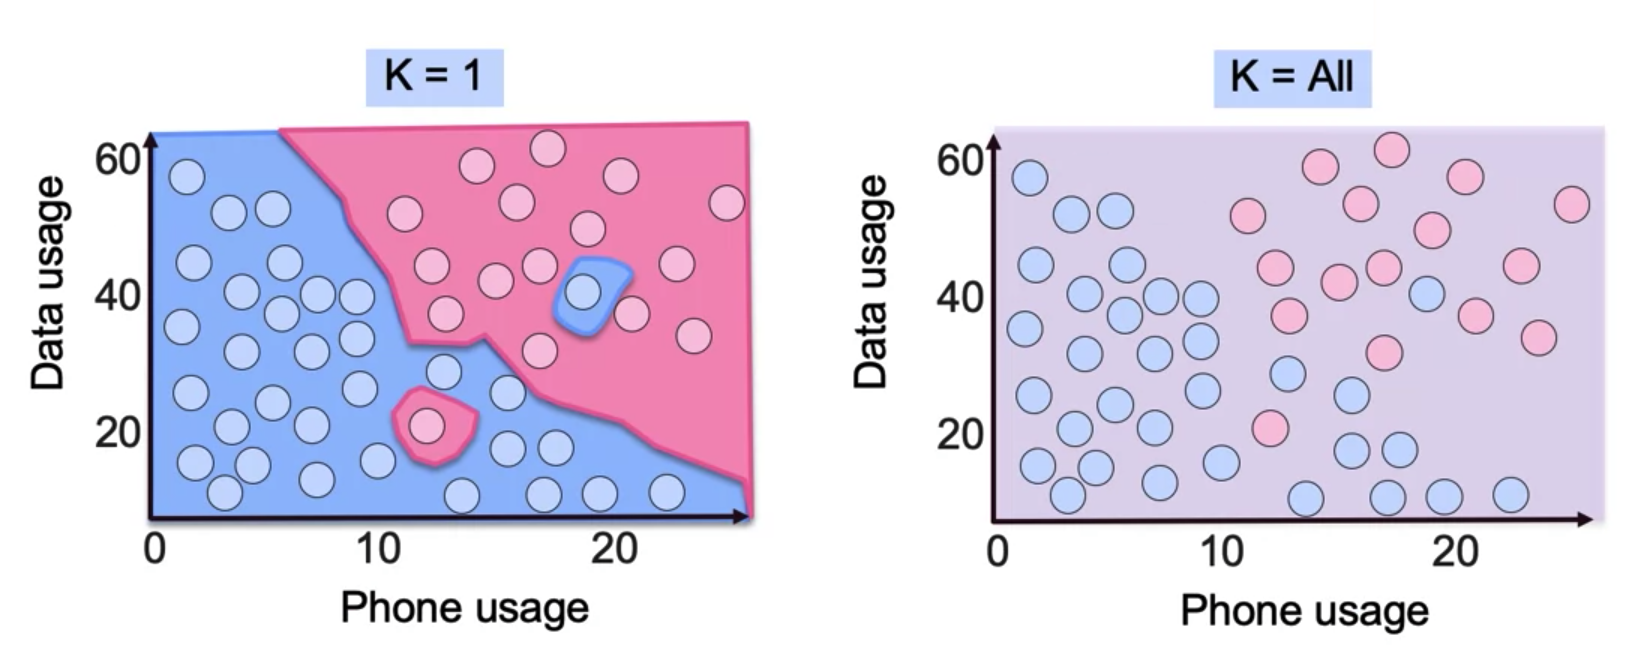

KNN does not provide us with the "correct K" but is a **Hyperparameter** that need to be tuned depending on the error metric we are trying to use.

A popular approach is the **Elbow Point:**

This emphasizes the kinks in a curve of the error rate as a function of K

<div>
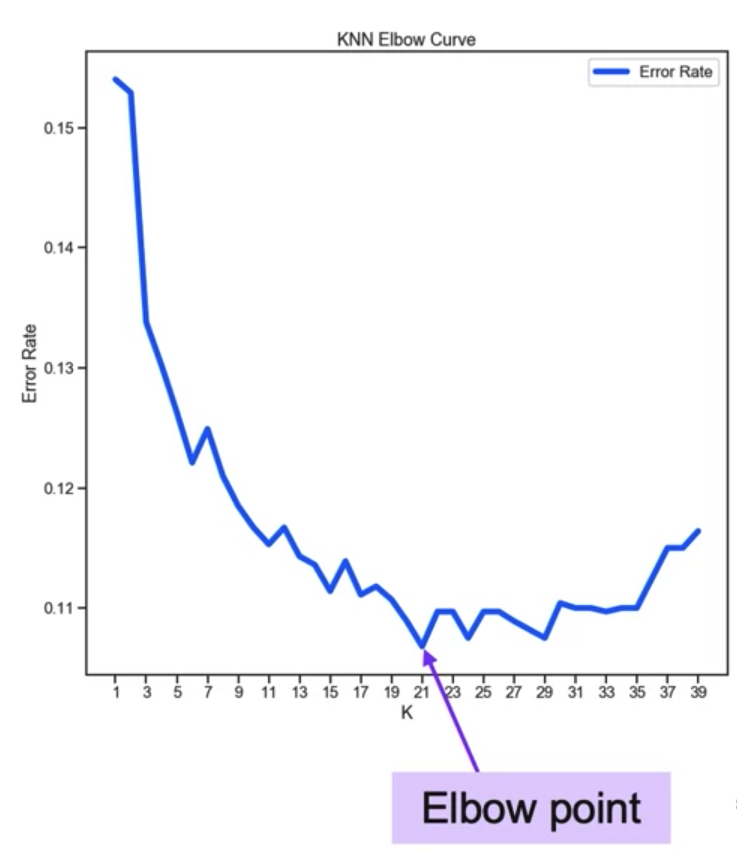
</div>

## 2. How to Measure Closeness of Neighbors

Or, how to measure the distance between two given points in KNN.

The **assumption** is that similar points will most likely have **similar outcomes**

## Euclidean Distance (L2)

for more dimensions we just add the additional dimensions to the formula

<div>
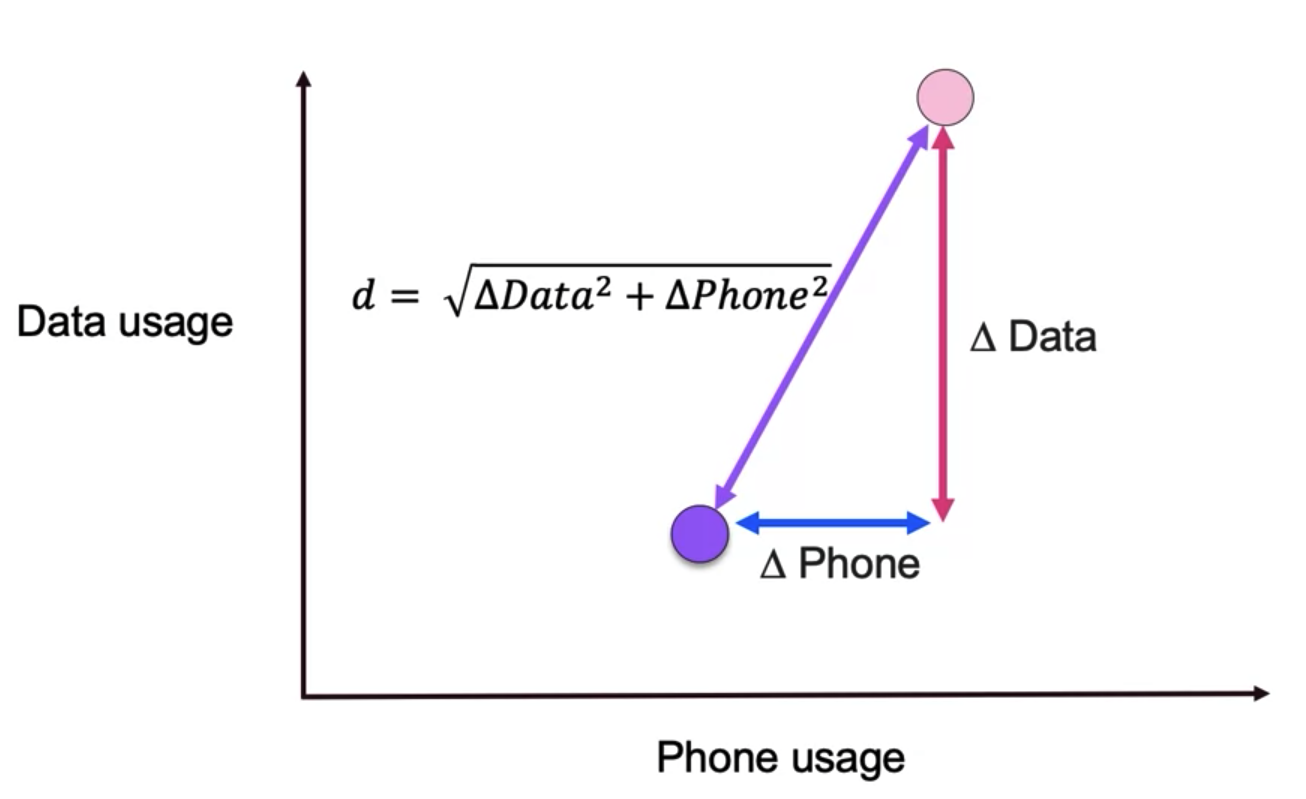
</div>

## Manhattan Distance (L1)

Since you cannot walk between two points directly you have to turn at that corner first

<div>
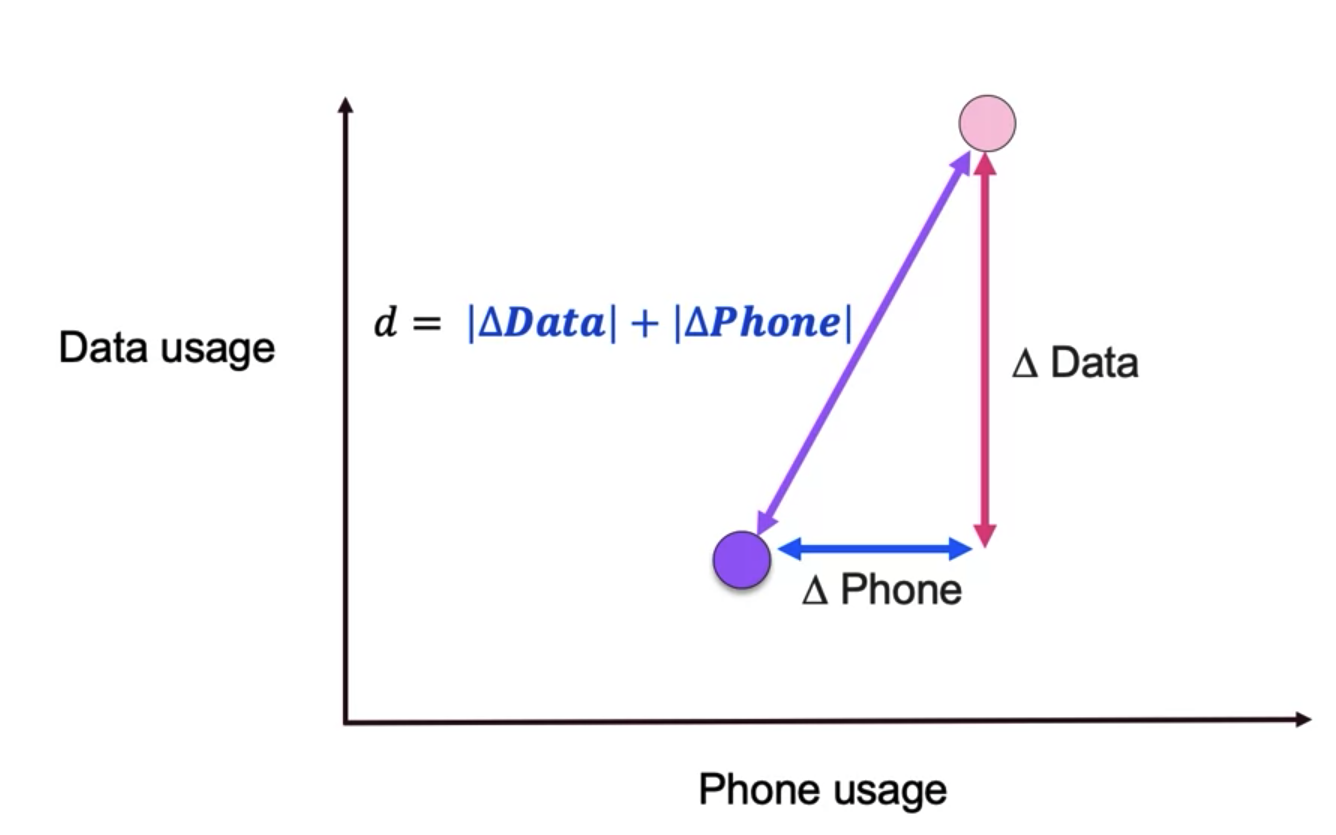
</div>

# Scale for Distance Measurement

Scaling is very important in KNN. We need to perform **Feature Scaling** on the data so as to have all measures on the same uniform scale:

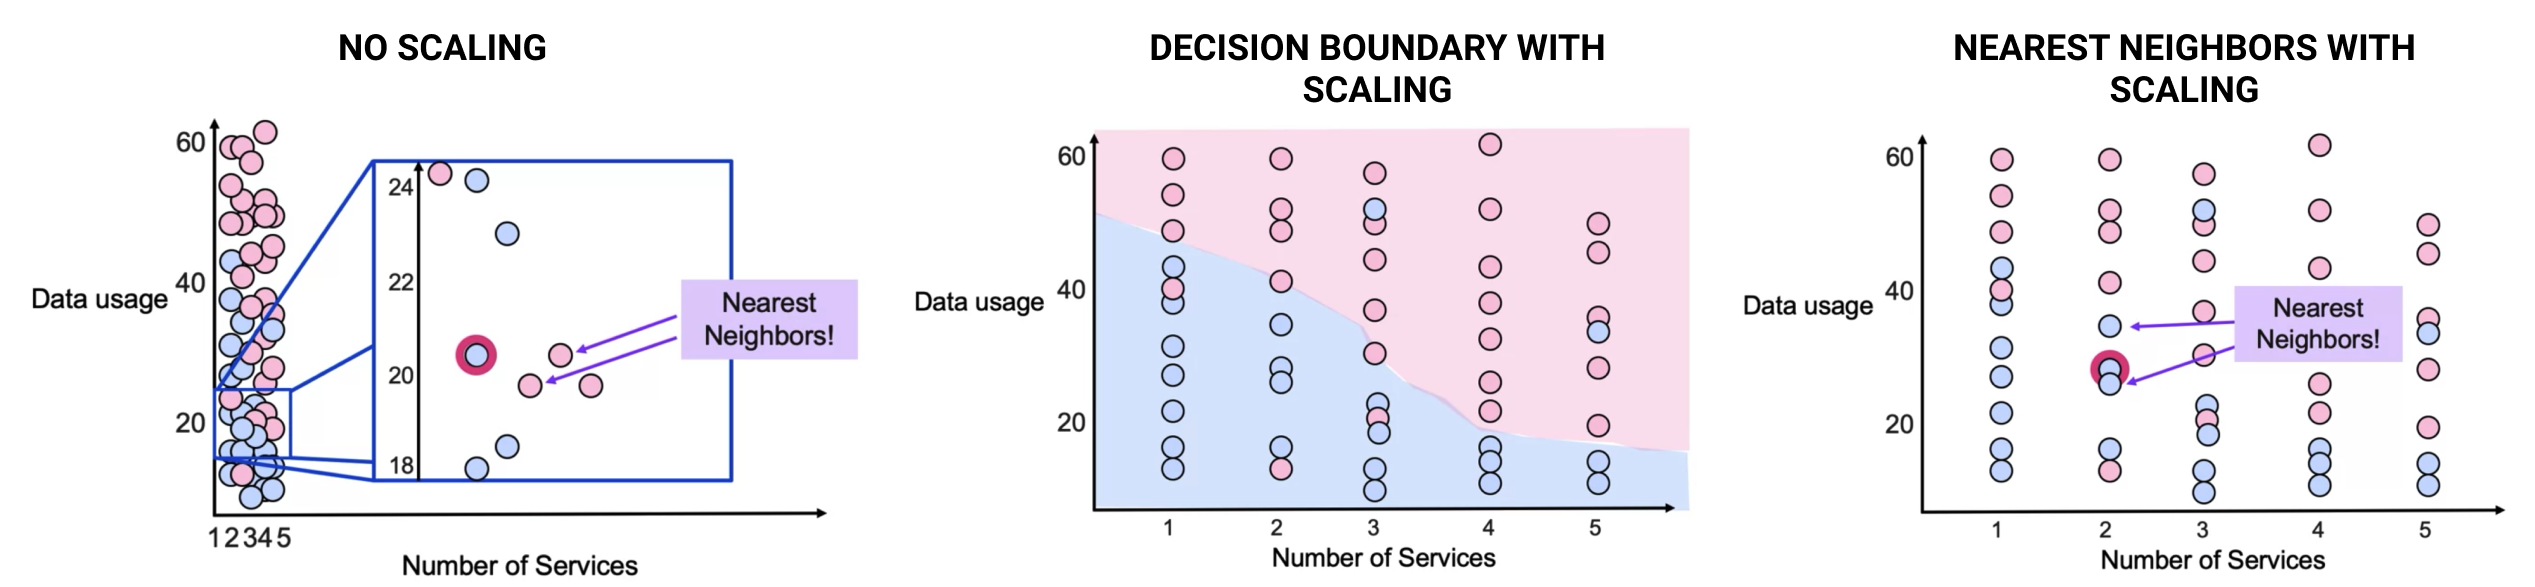

# KNN for Regression

We can predict continuous values as well, working in the same way as with classification except that the value predicted is the **Mean Value of its Neighbors**.

- When **K is the same value of the points**, a single value is predicted (K=20) i.e. the mean of all values will be predicted


- When **K is larger than 1**, KNN regression acts as a **smoothening function** that is just the rolling average of the closest K (in this case 3) points


- When **K = 1** the prediction connecs each point exactly

<div>
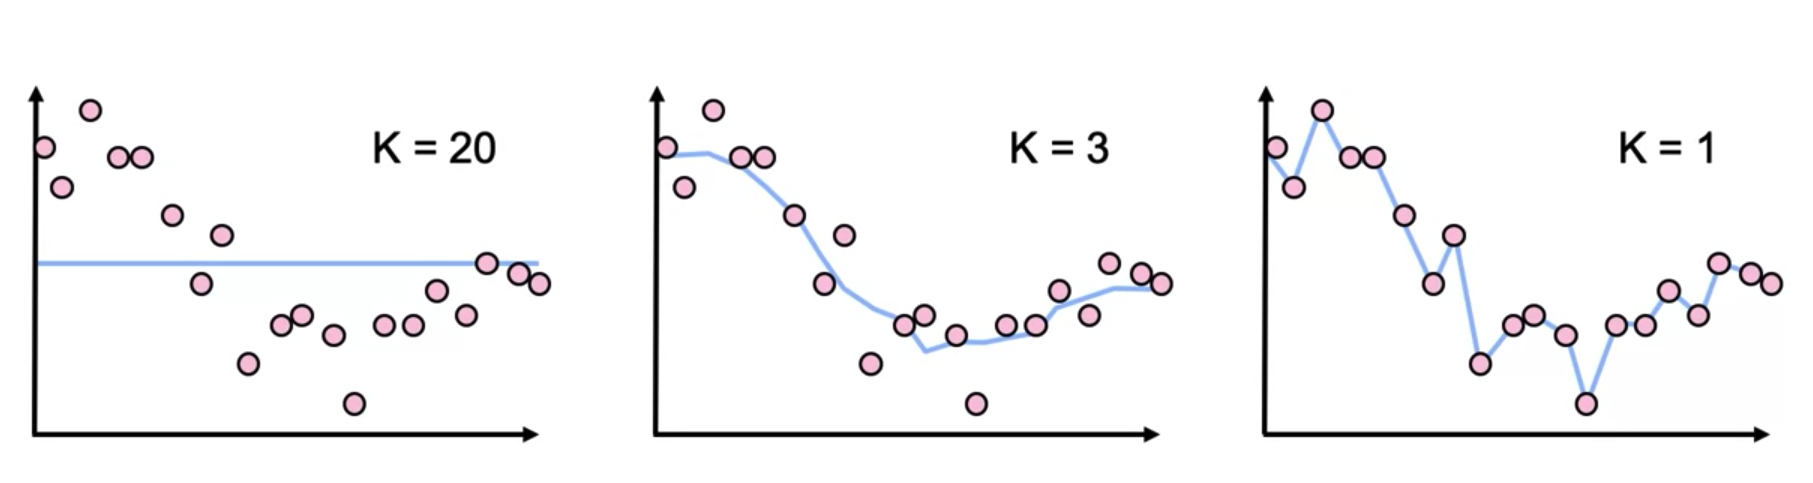
</div>

# Characteristics of a KNN Model

<div>
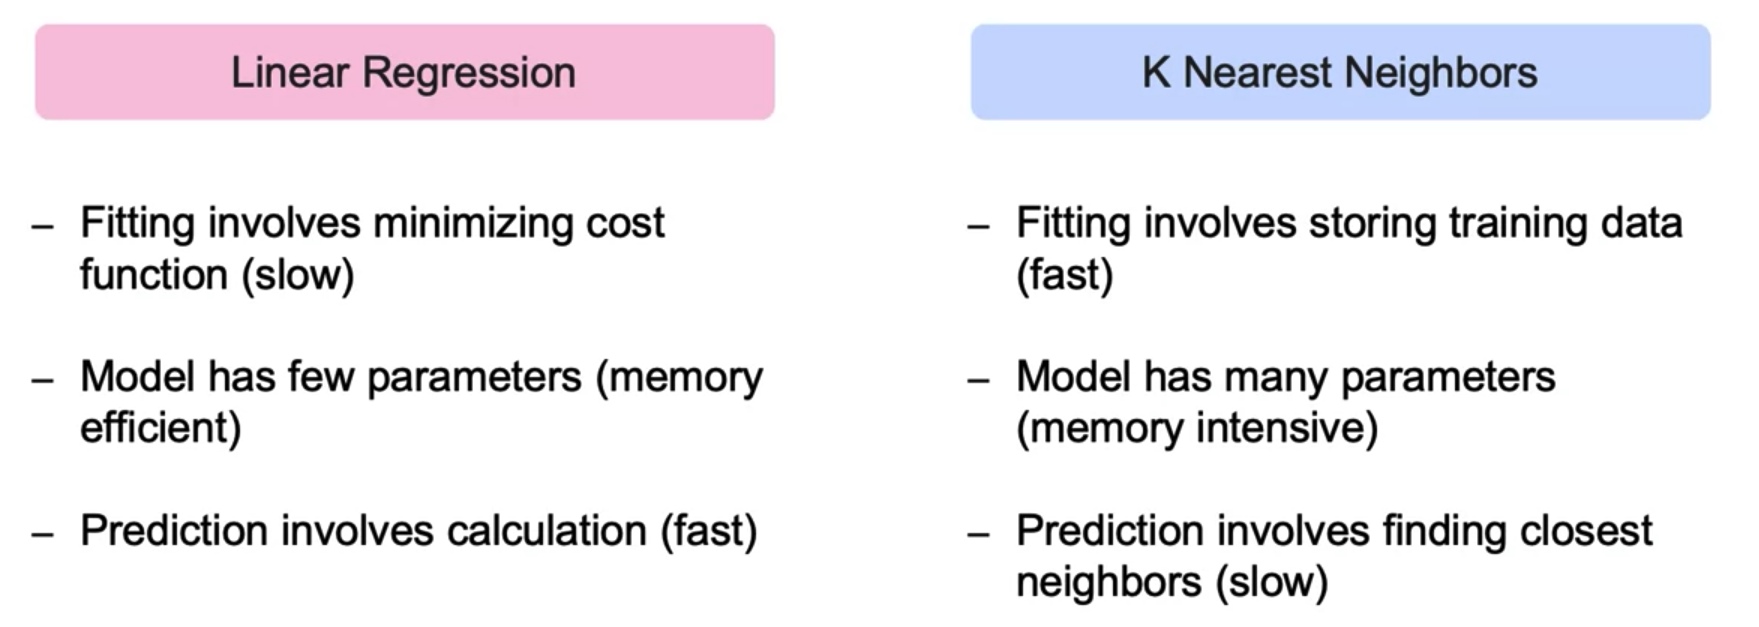
</div>

# Implementation in Python

```python

# Import the class containing the classification method
from sklearn.neighbors import KNeighborsClassifier

# Create an instance of the class
KNN = KNeighborsClassifier(n_neighbors=3)

# Fit the instance on the data and then predict the expected value
KNN = KNN.fit(X_train, y_train)
y_predict = KNN.predict(X_test

```


* Now that the data are encoded and scaled, separate the features (X) from the target (y, churn_value). 


* Split the sample into training and test samples, with the test sample representing 40% of observations.


* Estimate a K-Nearest Neighbors model, using K=3.


* Examine the Precision, Recall, F-1 Score, and Accuracy of the classification.


* Use a graphic to illustrate the Confusion Matrix 

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [117]:
# Set up X and y variables
y, X = df['churn_value'], df.drop(columns='churn_value')

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

0 = No Churn


1 = Churn

In [118]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Precision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2048
           1       0.77      0.72      0.74       770

    accuracy                           0.86      2818
   macro avg       0.83      0.82      0.82      2818
weighted avg       0.86      0.86      0.86      2818

Accuracy score:  0.86
F1 Score:  0.74


In [119]:
confusion_matrix(y_test, y_pred)

array([[1879,  169],
       [ 216,  554]])

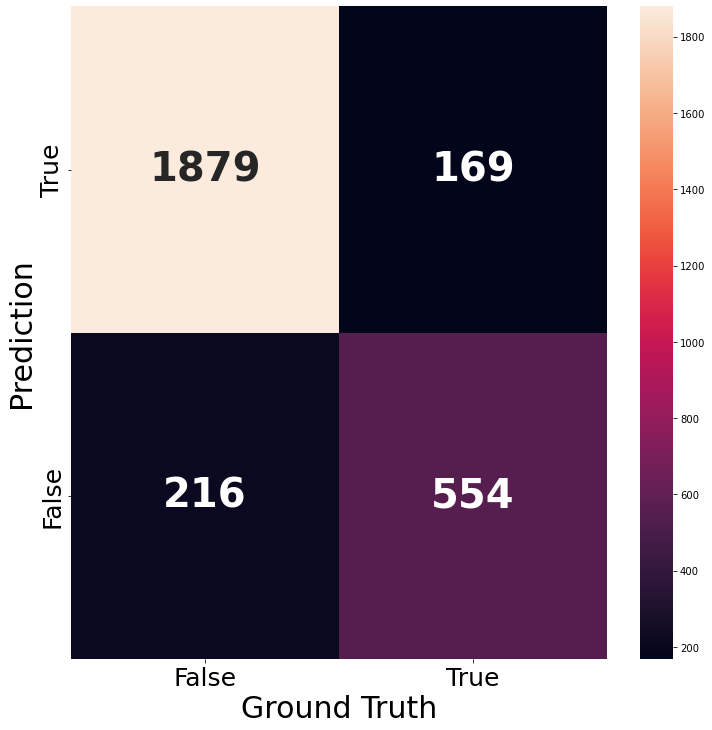

In [120]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(12,12))

ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  

labels = ['False', 'True']

ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);

# columns are the prediction
ax.set_ylabel('Prediction', fontsize=30);

# rows are ground truth
ax.set_xlabel('Ground Truth', fontsize=30)
plt.show()

# KNN with K = 5

* Using the same split of training and test samples, estimate another K-Nearest Neighbors model


* This time, use K=5 and weight the results by distance


* Again, examine the Precision, Recall, F-1 Score, and Accuracy of the classification, and visualize the Confusion Matrix. 

In [121]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


# Precision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2048
           1       0.78      0.74      0.76       770

    accuracy                           0.87      2818
   macro avg       0.84      0.83      0.84      2818
weighted avg       0.87      0.87      0.87      2818

Accuracy score:  0.87
F1 Score:  0.76


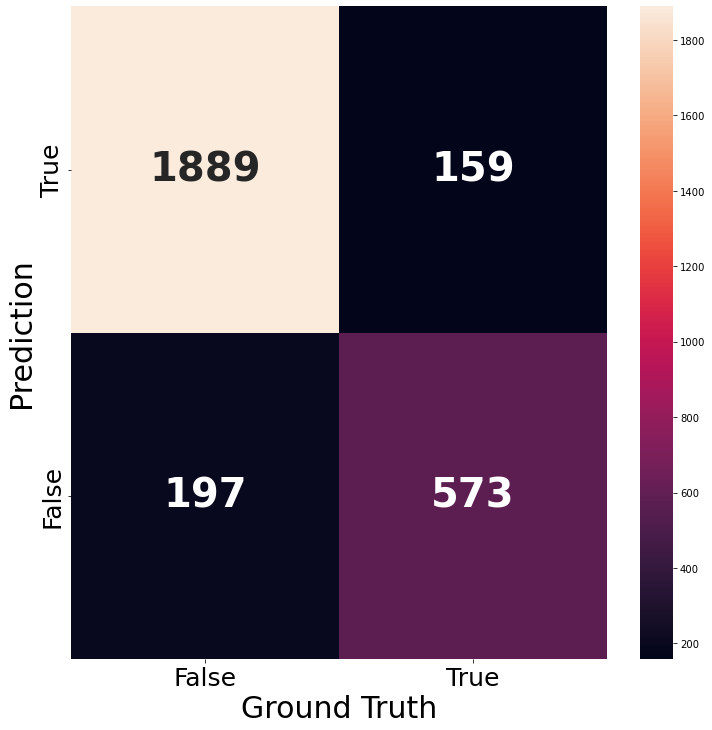

In [123]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
                 fmt='d', annot_kws={"size": 40, "weight": "bold"})  

labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
plt.show()

# Determine the Optimal Value for K

* To determine the right value for K, examing results for values of K from 1 to 40.


* This time, focus on two measures, the F-1 Score, and the Error Rate (1-Accuracy)


* Generate charts which plot each of these measures as a function of K. 


In [124]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

# keep initialiting the KNN and look at the F1 score and look at the one that maximises it
for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

In [126]:
f1_results.head()

,K,F1 Score
0,1,0.7211
1,2,0.7221
2,3,0.7492
3,4,0.7555
4,5,0.7630


In [127]:
error_results.head()

,K,Error Rate
0,1,0.1540
1,2,0.1529
2,3,0.1338
3,4,0.1302
4,5,0.1263


As we increase K the F1 Scores increase but plateau at a certain point at the 21 K mark

<Figure size 1800x1200 with 0 Axes>

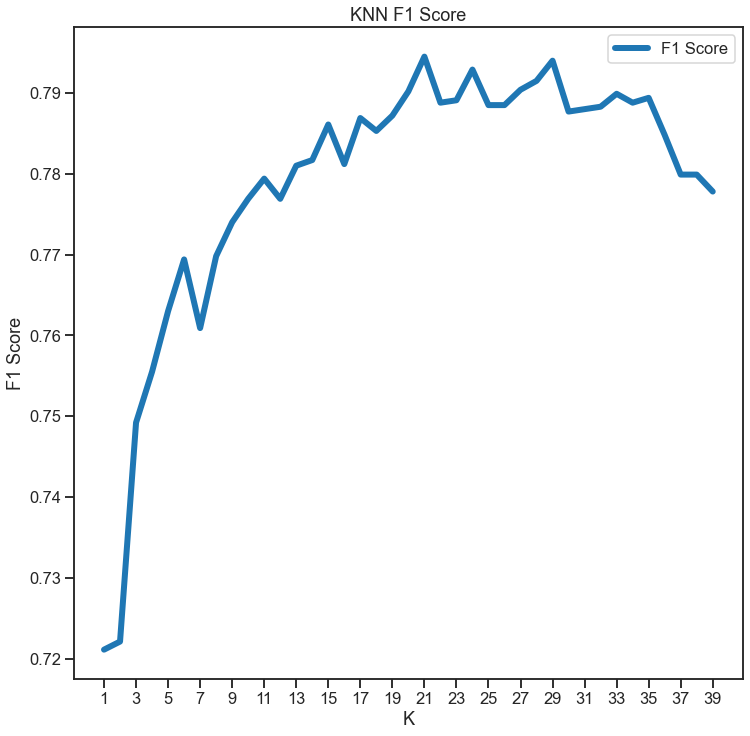

In [129]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')
plt.show()

Plot using the **Error Results** with threshold again at the 21 K mark

<Figure size 1800x1200 with 0 Axes>

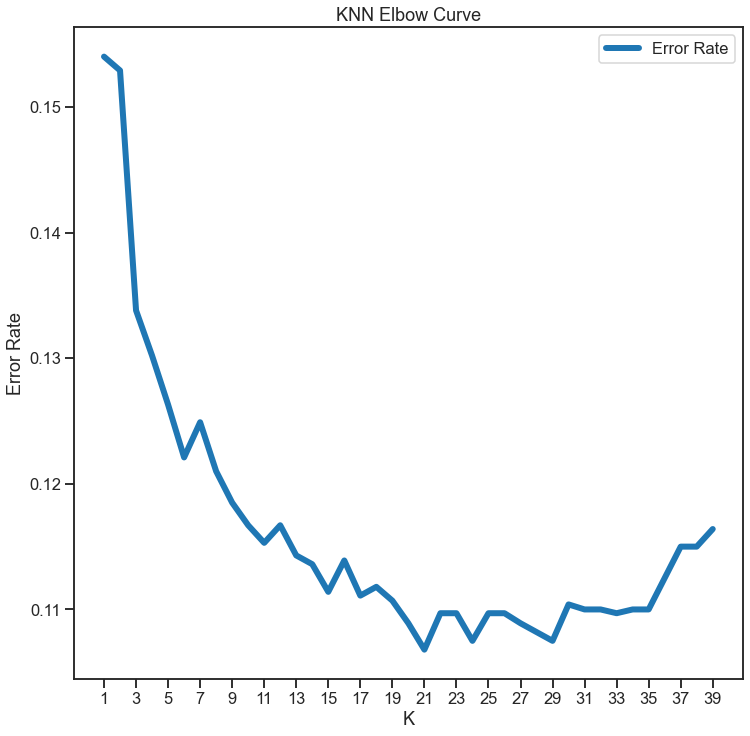

In [131]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')
plt.show()x